In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score
import statistics as stats

In [15]:
# Se importan las librerías de AdaBoost y de árboles de decisión 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.metrics import geometric_mean_score
from sklearn.metrics import balanced_accuracy_score
from imblearn.ensemble import RUSBoostClassifier

from imblearn.datasets import fetch_datasets

In [16]:
# def mostrar(X, y, clasificador=None, title=None):
#     """
#     Esta función muestra las fronteras de decisión del clasificador ya entrenado y los ejemplos en X
#     (con el color dependiendo de y).
#     :param clasificador: Clasificador entrenado de scikit-learn
#     :param X: Matriz con los ejemplos a mostrar
#     :param y: Vector con las salidas de los ejemplos a mostrar
#     :return: Nada
#     """
#     # Creamos los mapas de colores a utilizar
#     cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFAA', '#AAAAFF'])
#     cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#FFFF00', '#0000FF'])

#     # Creamos la figura
#     plt.figure(figsize=(10,8))

#     # Primer plot a la izquierda
#     plt.subplot(111)

#     if clasificador is not None:
#         # Preparamos los ejemplos de entrada para poder pintar la frontera de decisión
#         # Asignamos una clase (color) a cada ejemplo de la malla en [x_min, x_max]x[y_min, y_max].
#         x_min, x_max = X[:, 0].min() * 0.9-0.05, X[:, 0].max() * 1.1
#         y_min, y_max = X[:, 1].min() * 0.9-0.05, X[:, 1].max() * 1.1
#         xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
#                              np.linspace(y_min, y_max, 200))

#         # Clasificamos los puntos
#         # <RELLENAR>
#         Z = clasificador.predict(np.hstack((xx.reshape(-1,1),yy.reshape(-1,1))))
#         # Ponemos el resultado en el formato deseado
#         # <RELLENAR>
#         Z = Z.reshape(xx.shape)
#         # Pintamos las fronteras
#         plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.2)
    
#     # Pintamos los puntos
#     plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, s=60)
#     # Asignamos el título
#     plt.xlabel('Variable 1')
#     plt.ylabel('Variable 2')
#     if title is None:
#         plt.title("Ejemplos de Train")
#     else:
#         # Establecemos el título recibido como parámetro
#         # <RELLENAR>
#         plt.title(title)    
    
#     if clasificador is not None:
#         # Establecemos los límites
#         plt.xlim(xx.min(), xx.max())
#         plt.ylim(yy.min(), yy.max())

    
#     # Mostramos la figura
#     plt.show()
#     return

Para mostrar los puntos en el scatter plot se debe escoger sólo dos atriubutos
NO SÉ HASTA QUÉ PUNTO TIENE SENTIDO Y SI ESTÁ BIEN

In [17]:
# X_train_2features = X_train[:,:2]
# X_test_2features = X_test[:,:2]
# # Se define el número de clasificadores base de AdaBoost (numClasificadoresBase)
# numClasificadoresBase = 10
# # Llamada al constructor del clasificador AdaBoost
# dtc = DecisionTreeClassifier(criterion='entropy', max_depth=1)
# adaboost = AdaBoostClassifier(base_estimator=dtc, n_estimators=numClasificadoresBase)
# # Entrenamiento del clasificador creado
# # <RELLENAR>
# adaboost.fit(X_train_2features,y_train)
# # Lista para almacenar el accuracy de cada clasificador base
# listaAcc = []
# # Por cada clasificador base
# for i in range(len(adaboost.estimators_)):
#     # Se calcula el porcentaje de acierto del clasificador base correspondiente: adaboost.estimators_[i]
#     # Redondear a dos decimales
#     acc = round(adaboost.estimators_[i].score(X_test_2features,y_test)*100,2)
#     # Se añade a la lista de accuracies
#     listaAcc.append(acc)
#     # Establecemos el título de la figura con el número de clasificador y su precisión en train
#     titulo = 'Clasificador {}, accuracy: {}%'.format(i, acc)
#     # Mostramos la figura con los datos de train y la frontera del clasificador correspondiente
#     # <RELLENAR>
#     mostrar(X_test_2features,y_test,clasificador = adaboost.estimators_[i],title=titulo)
# print(listaAcc)

# SMOTE-Boost (SBO)

In [18]:
from collections import Counter

import numpy as np
from sklearn.base import is_regressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble.forest import BaseForest
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from sklearn.tree.tree import BaseDecisionTree
from sklearn.utils import check_random_state
from sklearn.utils import check_X_y
#from sklearn.utils import shuffle


class SMOTE(object):
    """Implementation of Synthetic Minority Over-Sampling Technique (SMOTE).
    SMOTE performs oversampling of the minority class by picking target 
    minority class samples and their nearest minority class neighbors and 
    generating new samples that linearly combine features of each target 
    sample with features of its selected minority class neighbors [1].
    Parameters
    ----------
    k_neighbors : int, optional (default=5)
        Number of nearest neighbors.
    random_state : int or None, optional (default=None)
        If int, random_state is the seed used by the random number generator.
        If None, the random number generator is the RandomState instance used
        by np.random.
    References
    ----------
    .. [1] N. V. Chawla, K. W. Bowyer, L. O. Hall, and P. Kegelmeyer. "SMOTE:
           Synthetic Minority Over-Sampling Technique." Journal of Artificial
           Intelligence Research (JAIR), 2002.
    """

    def __init__(self, k_neighbors=5, random_state=None):
        self.k = k_neighbors
        self.random_state = random_state

    def sample(self, n_samples):
        """Generate samples.
        Parameters
        ----------
        n_samples : int
            Number of new synthetic samples.
        Returns
        -------
        S : array, shape = [n_samples, n_features]
            Returns synthetic samples.
        """
        np.random.seed(seed=self.random_state)

        S = np.zeros(shape=(n_samples, self.n_features))
        # Calculate synthetic samples.
        for i in range(n_samples):
            j = np.random.randint(0, self.X.shape[0])

            # Find the NN for each sample.
            # Exclude the sample itself.
            nn = self.neigh.kneighbors(self.X[j].reshape(1, -1),
                                       return_distance=False)[:, 1:]
            nn_index = np.random.choice(nn[0])

            dif = self.X[nn_index] - self.X[j]
            gap = np.random.random()

            S[i, :] = self.X[j, :] + gap * dif[:]

        return S

    def fit(self, X):
        """Train model based on input data.
        Parameters
        ----------
        X : array-like, shape = [n_minority_samples, n_features]
            Holds the minority samples.
        """
        self.X = X
        self.n_minority_samples, self.n_features = self.X.shape

        # Learn nearest neighbors.
        self.neigh = NearestNeighbors(n_neighbors=self.k + 1)
        self.neigh.fit(self.X)

        return self


class SMOTEBoost(AdaBoostClassifier):
    """Implementation of SMOTEBoost.
    SMOTEBoost introduces data sampling into the AdaBoost algorithm by
    oversampling the minority class using SMOTE on each boosting iteration [1].
    This implementation inherits methods from the scikit-learn 
    AdaBoostClassifier class, only modifying the `fit` method.
    Parameters
    ----------
    n_samples : int, optional (default=100)
        Number of new synthetic samples per boosting step.
    k_neighbors : int, optional (default=5)
        Number of nearest neighbors.
    base_estimator : object, optional (default=DecisionTreeClassifier)
        The base estimator from which the boosted ensemble is built.
        Support for sample weighting is required, as well as proper `classes_`
        and `n_classes_` attributes.
    n_estimators : int, optional (default=50)
        The maximum number of estimators at which boosting is terminated.
        In case of perfect fit, the learning procedure is stopped early.
    learning_rate : float, optional (default=1.)
        Learning rate shrinks the contribution of each classifier by
        ``learning_rate``. There is a trade-off between ``learning_rate`` and
        ``n_estimators``.
    algorithm : {'SAMME', 'SAMME.R'}, optional (default='SAMME.R')
        If 'SAMME.R' then use the SAMME.R real boosting algorithm.
        ``base_estimator`` must support calculation of class probabilities.
        If 'SAMME' then use the SAMME discrete boosting algorithm.
        The SAMME.R algorithm typically converges faster than SAMME,
        achieving a lower test error with fewer boosting iterations.
    random_state : int or None, optional (default=None)
        If int, random_state is the seed used by the random number generator.
        If None, the random number generator is the RandomState instance used
        by np.random.
    References
    ----------
    .. [1] N. V. Chawla, A. Lazarevic, L. O. Hall, and K. W. Bowyer.
           "SMOTEBoost: Improving Prediction of the Minority Class in
           Boosting." European Conference on Principles of Data Mining and
           Knowledge Discovery (PKDD), 2003.
    """

    def __init__(self,
                 n_samples=100,
                 k_neighbors=5,
                 base_estimator=None,
                 n_estimators=50,
                 learning_rate=1.,
                 algorithm='SAMME.R',
                 random_state=None):

        self.n_samples = n_samples
        self.algorithm = algorithm
        self.smote = SMOTE(k_neighbors=k_neighbors,
                           random_state=random_state)

        super(SMOTEBoost, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state)

    def fit(self, X, y, sample_weight=None, minority_target=None):
        """Build a boosted classifier/regressor from the training set (X, y),
        performing SMOTE during each boosting step.
        Parameters
        ----------
        X : {array-like, sparse matrix} of shape = [n_samples, n_features]
            The training input samples. Sparse matrix can be CSC, CSR, COO,
            DOK, or LIL. COO, DOK, and LIL are converted to CSR. The dtype is
            forced to DTYPE from tree._tree if the base classifier of this
            ensemble weighted boosting classifier is a tree or forest.
        y : array-like of shape = [n_samples]
            The target values (class labels in classification, real numbers in
            regression).
        sample_weight : array-like of shape = [n_samples], optional
            Sample weights. If None, the sample weights are initialized to
            1 / n_samples.
        minority_target : int
            Minority class label.
        Returns
        -------
        self : object
            Returns self.
        Notes
        -----
        Based on the scikit-learn v0.18 AdaBoostClassifier and
        BaseWeightBoosting `fit` methods.
        """
        # Check that algorithm is supported.
        if self.algorithm not in ('SAMME', 'SAMME.R'):
            raise ValueError("algorithm %s is not supported" % self.algorithm)

        # Check parameters.
        if self.learning_rate <= 0:
            raise ValueError("learning_rate must be greater than zero")

        if (self.base_estimator is None or
                isinstance(self.base_estimator, (BaseDecisionTree,
                                                 BaseForest))):
            DTYPE = np.float64  # from fast_dict.pxd
            dtype = DTYPE
            accept_sparse = 'csc'
        else:
            dtype = None
            accept_sparse = ['csr', 'csc']

        X, y = check_X_y(X, y, accept_sparse=accept_sparse, dtype=dtype,
                         y_numeric=is_regressor(self))

        if sample_weight is None:
            # Initialize weights to 1 / n_samples.
            sample_weight = np.empty(X.shape[0], dtype=np.float64)
            sample_weight[:] = 1. / X.shape[0]
        else:
            sample_weight = check_array(sample_weight, ensure_2d=False)
            # Normalize existing weights.
            sample_weight = sample_weight / sample_weight.sum(dtype=np.float64)

            # Check that the sample weights sum is positive.
            if sample_weight.sum() <= 0:
                raise ValueError(
                    "Attempting to fit with a non-positive "
                    "weighted number of samples.")

        if minority_target is None:
            # Determine the minority class label.
            stats_c_ = Counter(y)
            maj_c_ = max(stats_c_, key=stats_c_.get)
            min_c_ = min(stats_c_, key=stats_c_.get)
            self.minority_target = min_c_
        else:
            self.minority_target = minority_target

        # Check parameters.
        self._validate_estimator()

        # Clear any previous fit results.
        self.estimators_ = []
        self.estimator_weights_ = np.zeros(self.n_estimators, dtype=np.float64)
        self.estimator_errors_ = np.ones(self.n_estimators, dtype=np.float64)

        random_state = check_random_state(self.random_state)

        for iboost in range(self.n_estimators):
            X_min = X[np.where(y == self.minority_target)]

            # SMOTE step.
            if len(X_min) >= self.smote.k:
                self.smote.fit(X_min)
                X_syn = self.smote.sample(self.n_samples)
                y_syn = np.full(X_syn.shape[0], fill_value=self.minority_target,
                                dtype=np.int64)

                # Normalize synthetic sample weights based on current training set.
                sample_weight_syn = np.empty(X_syn.shape[0], dtype=np.float64)
                sample_weight_syn[:] = 1. / X.shape[0]

                # Combine the original and synthetic samples.
                X = np.vstack((X, X_syn))
                y = np.append(y, y_syn)

                # Combine the weights.
                sample_weight = \
                    np.append(sample_weight, sample_weight_syn).reshape(-1, 1)
                sample_weight = \
                    np.squeeze(normalize(sample_weight, axis=0, norm='l1'))

                # X, y, sample_weight = shuffle(X, y, sample_weight,
                #                              random_state=random_state)

            # Boosting step.
            sample_weight, estimator_weight, estimator_error = self._boost(
                iboost,
                X, y,
                sample_weight,
                random_state)

            # Early termination.
            if sample_weight is None:
                break

            self.estimator_weights_[iboost] = estimator_weight
            self.estimator_errors_[iboost] = estimator_error

            # Stop if error is zero.
            if estimator_error == 0:
                break

            sample_weight_sum = np.sum(sample_weight)

            # Stop if the sum of sample weights has become non-positive.
            if sample_weight_sum <= 0:
                break

            if iboost < self.n_estimators - 1:
                # Normalize.
                sample_weight /= sample_weight_sum

        return self

In [19]:
# from imblearn.ensemble import RUSBoostClassifier
# from sklearn.metrics import classification_report
# target_names = ['-1','1']

# for algorithm in [AdaBoostClassifier(base_estimator=dtc, n_estimators=numClasificadoresBase),
#                   SMOTEBoost(n_estimators=10,k_neighbors = 5),
#                   RUSBoost(n_estimators=10),
#                   RUSBoostClassifier()]:
#     algorithm.fit(X_train, y_train)
#     y_pred = algorithm.predict(X_test)
#     print()
#     print(str(algorithm))
#     print()
#     print(classification_report(y_test, y_pred, 
#                                 target_names=target_names))

# KEEL DATASETS
Functions to read and obtain data from keel datasets

In [20]:
def intLabel(c):
    if c==b'negative':
        return -1
    else:
        return 1
    
def obtain_keel_glass0123vs456_data():
    filepath= "../keel_datasets/glass/glass-0-1-2-3_vs_4-5-6.dat"
    dataset = np.loadtxt(filepath,comments='@',delimiter=", ",
              converters = {9: intLabel})
    X, y = dataset[:,:-1],dataset[:,-1]
    print(X)
    print(y)
    return X,y

def obtain_keel_pima_data():
    filepath= "../keel_datasets/pima/pima.dat"
    dataset = np.loadtxt(filepath,comments='@',delimiter=",",
          converters = {8: intLabel})
    X, y = dataset[:,:-1],dataset[:,-1]
    print(X)
    print(y)
    return X,y


In [116]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
target_names = ['-1','1']

for algorithm in [#AdaBoostClassifier(base_estimator=SVC(), algorithm='SAMME', n_estimators=numClasificadoresBase),
                  AdaBoostClassifier(base_estimator=dtc, n_estimators=numClasificadoresBase),
                  SMOTEBoost(n_estimators=10,k_neighbors = 5),
                  RUSBoost(n_estimators=10),
                  RUSBoostClassifier()]:
    algorithm.fit(X_train, y_train)
    y_pred = algorithm.predict(X_test)
    print()
    print(str(algorithm))
    print()
    print(classification_report(y_test, y_pred, 
                                target_names=target_names))
    gmean = geometric_mean_score(y_test, y_pred)
    print("Gmean: ",gmean)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=1),
                   n_estimators=10)

              precision    recall  f1-score   support

          -1       1.00      0.90      0.95        41
           1       0.76      1.00      0.87        13

    accuracy                           0.93        54
   macro avg       0.88      0.95      0.91        54
weighted avg       0.94      0.93      0.93        54

Gmean:  0.9499679070317291

SMOTEBoost(k_neighbors=None, n_estimators=10)

              precision    recall  f1-score   support

          -1       1.00      0.90      0.95        41
           1       0.76      1.00      0.87        13

    accuracy                           0.93        54
   macro avg       0.88      0.95      0.91        54
weighted avg       0.94      0.93      0.93        54

Gmean:  0.9499679070317291

RUSBoost(n_estimators=10, n_samples=0, with_replacement=

/home/cristina/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/cristina/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


In [123]:
from imblearn.ensemble import RUSBoostClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
target_names = ['-1','1']

for algorithm in [#AdaBoostClassifier(base_estimator=SVC(), algorithm='SAMME', n_estimators=numClasificadoresBase),
                  AdaBoostClassifier(base_estimator=dtc, n_estimators=numClasificadoresBase),
                  SMOTEBoost(n_estimators=10,k_neighbors = 5),
                  RUSBoost(n_estimators=10),
                  RUSBoostClassifier()]:
    algorithm.fit(X_train, y_train)
    y_pred = algorithm.predict(X_test)
    print()
    print(str(algorithm))
    print()
    print(classification_report(y_test, y_pred, 
                                target_names=target_names))
    gmean = geometric_mean_score(y_test, y_pred)
    print("Gmean: ",gmean)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=1),
                   n_estimators=10)

              precision    recall  f1-score   support

          -1       0.81      0.83      0.82       125
           1       0.67      0.64      0.66        67

    accuracy                           0.77       192
   macro avg       0.74      0.74      0.74       192
weighted avg       0.76      0.77      0.76       192

Gmean:  0.7307326113249164

SMOTEBoost(k_neighbors=None, n_estimators=10)

              precision    recall  f1-score   support

          -1       0.88      0.60      0.71       125
           1       0.53      0.85      0.66        67

    accuracy                           0.69       192
   macro avg       0.71      0.73      0.68       192
weighted avg       0.76      0.69      0.69       192

Gmean:  0.7144562696162935

RUSBoost(n_estimators=10, n_samples=0, with_replacement=

/home/cristina/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '
/home/cristina/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


# GENERAL FUNCTIONS

In [21]:
def obtain_data(dataset_name):
    dataset = fetch_datasets()[dataset_name]
    return dataset.data,dataset.target

In [22]:
def convert_classes(y):
    default_classes = np.unique(y)
#     print("Default classes of the dataset were: ",default_classes)
    maj_class = -1
    min_class = 1
    if sum(y == default_classes[0]) > sum(y == default_classes[1]):
        y[y==default_classes[0]] = maj_class
        y[y==default_classes[1]] = min_class
    else:
        y[y==default_classes[1]] = maj_class
        y[y==default_classes[0]] = min_class

    return [maj_class,min_class], maj_class, min_class

In [10]:
def train(X_train, y_train, method_name, base_classifier, T, min_class):
    if method_name=='adaboost':
        clf = AdaBoostClassifier(base_estimator=base_classifier, n_estimators=T)
    elif method_name=='RUSBoost':
        clf = RUSBoostClassifier(base_estimator=base_classifier,n_estimators=T,sampling_strategy='majority')
    elif method_name=='SMOTEBoost':
        clf = SMOTEBoost(n_samples=X_train[y_train==min_class].shape[0], base_estimator=base_classifier,
                        n_estimators=T)
    clf.fit(X_train,y_train)
    return clf

In [11]:
def gmean_test(clf, X_test, y_test):
    # Se calcula el porcentaje de acierto de AdaBoost
#     acc = clf.score(X_test,y_test)*100
    y_pred = clf.predict(X_test)
    gmean = geometric_mean_score(y_test, y_pred)*100
#     bAcc = balanced_accuracy_score(y_test, y_pred)*100
    
    return gmean

In [12]:
def train_ensemble_method(dataset_name,method_name, T=10, k=5):
    #fetch data from dataset
#     X, y = obtain_data(dataset_name)
    if dataset_name=='glass0123vs456':
        X, y = obtain_keel_glass0123vs456_data()
    elif dataset_name=='pima':
        X, y = obtain_keel_pima_data()
    print("Dataset of size {}".format(X.shape))
    
    #convert, just in case, class labels to -1 (majoritary class) and 1 (minoritari class)
    classes, maj_class, min_class = convert_classes(y)
    
    #number of instances of each class and IR
    n_maj = X[y==maj_class].shape[0]
    n_min = X[y==min_class].shape[0]
    IR = n_maj/n_min
    print("There are {} instances for the majoritary class".format(n_maj))
    print("There are {} instanes for the minoritary class".format(n_min))
    print("IR of the dataset: ",IR)
    
    # Llamada al constructor del clasificador 
    dtc = DecisionTreeClassifier(criterion='entropy', max_depth=1)

    kf = StratifiedKFold(n_splits=k)

    accGlobal = []
    gmean = []
    baccGlobal = []
    for train_index, test_index in kf.split(X,y):
    #     print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf = train(X_train, y_train, method_name, dtc, T, min_class)
        
        partial_gmean = gmean_test(clf, X_test, y_test)
        
        gmean.append(partial_gmean)
        
    print(gmean)
    rend = stats.mean(gmean)
    print("Rendimiento del clasificador {}: {}".format(method_name,rend))
    return rend, IR
    

In [13]:
keel_datasets = [
    'glass0123vs456',
    'pima'
]

In [13]:
rend = np.empty((3,len(keel_datasets)))
# IRlista = []
for i,algorithm in enumerate(['SMOTEBoost','RUSBoost','adaboost']):
    for j,dataset in enumerate(imblearn_datasets):
        print(dataset.upper()+' with '+algorithm)
        r, IR = train_ensemble_method(dataset,algorithm)
        rend[i,j] = r
#         IRlista.append(IR)
        print()

ECOLIwithSMOTEBoost
Dataset of size (336, 7)
There are 301 instances for the majoritary class
There are 35 instanes for the minoritary class
IR of the dataset:  8.6
[100.0, 92.58200997725514, 81.06434833777776, 57.94085654478071, 91.80725150319788]
Rendimiento del clasificador SMOTEBoost: 84.6788932726023

OPTICAL_DIGITSwithSMOTEBoost
Dataset of size (5620, 64)
There are 5066 instances for the majoritary class
There are 554 instanes for the minoritary class
IR of the dataset:  9.144404332129964
[90.76211895808866, 89.43108489557254, 87.71055981585914, 89.9818012859673, 82.17081755387781]
Rendimiento del clasificador SMOTEBoost: 88.01127650187308

SATIMAGEwithSMOTEBoost
Dataset of size (6435, 36)
There are 5809 instances for the majoritary class
There are 626 instanes for the minoritary class
IR of the dataset:  9.279552715654953
[83.56884677595471, 59.46230672305071, 88.77828268650053, 83.25313409926018, 84.15472308750549]
Rendimiento del clasificador SMOTEBoost: 79.84345867445433

PEN

[80.32235705001477, 74.07827085583646, 74.26753164028582, 82.61240709227057, 80.21021444296352]
Rendimiento del clasificador SMOTEBoost: 78.29815621627424

PROTEIN_HOMOwithSMOTEBoost
Dataset of size (145751, 74)
There are 144455 instances for the majoritary class
There are 1296 instanes for the minoritary class
IR of the dataset:  111.4621913580247
[68.4280675463979, 91.47326600523327, 83.75915132079916, 84.26043517138648, 87.52899121935171]
Rendimiento del clasificador SMOTEBoost: 83.0899822526337

ABALONE_19withSMOTEBoost
Dataset of size (4177, 10)
There are 4145 instances for the majoritary class
There are 32 instanes for the minoritary class
IR of the dataset:  129.53125
[0.0, 0.0, 0.0, 0.0, 0.0]
Rendimiento del clasificador SMOTEBoost: 0.0

ECOLIwithRUSBoost
Dataset of size (336, 7)
There are 301 instances for the majoritary class
There are 35 instanes for the minoritary class
IR of the dataset:  8.6
[83.1183800695515, 73.67883976130072, 77.45966692414832, 67.61234037828132, 84.51

[68.40052490845876, 70.03533446699686, 63.7586404448293, 38.01943712528834, 20.151708874395133]
Rendimiento del clasificador RUSBoost: 52.07312916399368

OZONE_LEVELwithRUSBoost
Dataset of size (2536, 72)
There are 2463 instances for the majoritary class
There are 73 instanes for the minoritary class
IR of the dataset:  33.73972602739726
[72.59322885963778, 39.189114923464366, 79.29711504437633, 72.69492998503029, 66.99108058576738]
Rendimiento del clasificador RUSBoost: 66.15309387965523

MAMMOGRAPHYwithRUSBoost
Dataset of size (11183, 6)
There are 10923 instances for the majoritary class
There are 260 instanes for the minoritary class
IR of the dataset:  42.011538461538464
[84.72700707486848, 87.68271841880669, 86.4728672369236, 84.05418709374914, 88.7586585333393]
Rendimiento del clasificador RUSBoost: 86.33908767153744

PROTEIN_HOMOwithRUSBoost
Dataset of size (145751, 74)
There are 144455 instances for the majoritary class
There are 1296 instanes for the minoritary class
IR of the

Dataset of size (1484, 8)
There are 1433 instances for the majoritary class
There are 51 instanes for the minoritary class
IR of the dataset:  28.098039215686274
[69.96763811416862, 44.25141978863621, 44.48701020135037, 60.19675305358698, 75.54001394157739]
Rendimiento del clasificador adaboost: 58.88856701986391

WEBPAGEwithadaboost
Dataset of size (34780, 300)
There are 33799 instances for the majoritary class
There are 981 instanes for the minoritary class
IR of the dataset:  34.45361875637105
[26.664773460549995, 26.688538860508558, 40.959686649719174, 17.342978159423257, 7.124704998790965]
Rendimiento del clasificador adaboost: 23.75613642579839

OZONE_LEVELwithadaboost
Dataset of size (2536, 72)
There are 2463 instances for the majoritary class
There are 73 instanes for the minoritary class
IR of the dataset:  33.73972602739726
[36.47778506496024, 37.294787679532796, 46.29100498862757, 44.447831849231534, 25.688355317458324]
Rendimiento del clasificador adaboost: 38.0399529799620

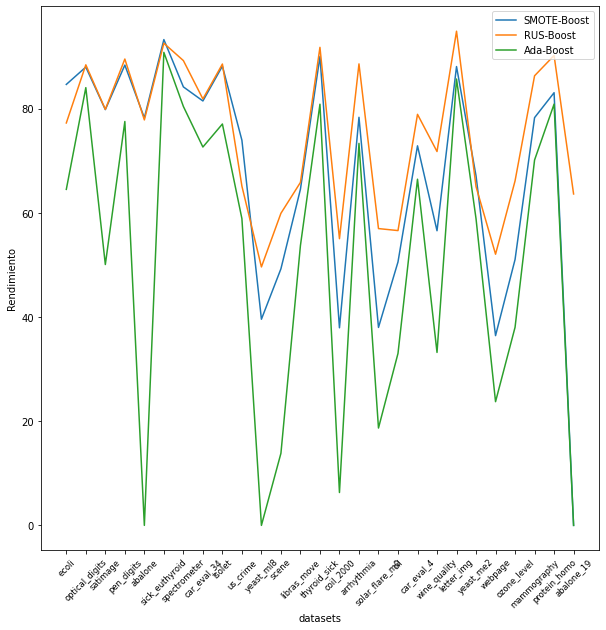

Media del rendimiento para los cuatro datasets con SMOTEBoost:  67.49256341244525
Media del rendimiento para los cuatro datasets con RUSBoost:  74.96759089477383
Media del rendimiento para los cuatro datasets con AdaBoost:  51.59867318519848


In [14]:
plt.figure(figsize=(10,10))
plt.plot(imblearn_datasets, rend[0,:], label = 'SMOTE-Boost')
plt.plot(imblearn_datasets, rend[1,:], label = 'RUS-Boost')
plt.plot(imblearn_datasets, rend[2,:], label = 'Ada-Boost')
plt.xticks(imblearn_datasets, size = 'small', rotation = 45)
plt.legend(loc='upper right')
plt.ylabel('Rendimiento')
plt.xlabel('datasets')
plt.show()

print("Media del rendimiento para los cuatro datasets con SMOTEBoost: ",stats.mean(rend[0]))
print("Media del rendimiento para los cuatro datasets con RUSBoost: ",stats.mean(rend[1]))
print("Media del rendimiento para los cuatro datasets con AdaBoost: ",stats.mean(rend[2]))

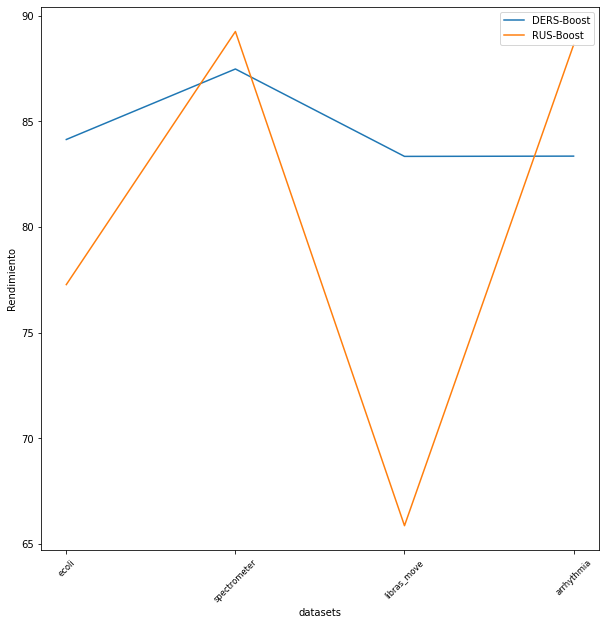

Media del rendimiento para los cuatro datasets con RUSBoost:  80.25508102695258
Media del rendimiento para los cuatro datasets con DERSBoost:  84.5831791390704


In [16]:
dersRends = [84.14589029802556, 87.48296830905146, 83.34580562998774, 83.35805231921684]
ders_datasets = ['ecoli','spectrometer','libras_move','arrhythmia']
rusRendsFiltered = []
for dataset in ders_datasets:
    idx = imblearn_datasets.index(dataset)
    rusRendsFiltered.append(rend[1][idx])

plt.figure(figsize=(10,10))
plt.plot(ders_datasets, dersRends, label = 'DERS-Boost')
plt.plot(ders_datasets, rusRendsFiltered, label = 'RUS-Boost')
plt.xticks(ders_datasets, size = 'small', rotation = 45)
plt.legend(loc='upper right')
plt.ylabel('Rendimiento')
plt.xlabel('datasets')
plt.show()

print("Media del rendimiento para los cuatro datasets con RUSBoost: ",stats.mean(rusRendsFiltered))
print("Media del rendimiento para los cuatro datasets con DERSBoost: ",stats.mean(dersRends))